# Kubeflow pipeline demo

### 1. Load data

#### Traditional way to write

In [3]:
"""
Load data from target resources
"""

import pandas as pd
from sklearn.datasets import fetch_california_housing


# Function to return the orignal data
def load_my_data_local():
    '''
    Load data
    '''
    # Load data
    cal_data = fetch_california_housing(as_frame=True)
    df = cal_data.frame

    # In reality, the data load process would be
    # requests, or pulling data from data warehouse
    # df = pd.read_csv(f"{loc}/{tablename}")

    return df


In [4]:
df = load_my_data_local()

In [5]:
df.to_csv('to_csv_test.csv', index=False, header=True)

In [6]:
df = pd.read_csv('to_csv_test.csv')

In [7]:
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


#### Kubeflow pipeline

In [8]:
import kfp
import kfp.components as comp


"""
Load data from target resources
"""
# Function to return the orignal data
def load_my_data(output_csv: comp.OutputPath('CSV')):
    '''
    Load data
    '''
    import pandas as pd
    from sklearn.datasets import fetch_california_housing
    
    # Load data
    cal_data = fetch_california_housing(as_frame=True)
    df = cal_data.frame

    # In reality, the data load process would be
    # requests, or pulling data from data warehouse
    # df = pd.read_csv(f"{loc}/{tablename}")
    
    # Create an output     
    df.to_csv(output_csv, index=False, header=True)


#### Create a pipeline component from the function

In [9]:
load_data_from_web = kfp.components.create_component_from_func(
    func=load_my_data,
    output_component_file='data_load.yaml', # This is optional. It saves the component spec for future use.
    base_image='python:3.10',
    packages_to_install=['pandas==1.5.3', 'scikit-learn==1.2.2'])

### 2. Preprocess the data

#### Tradtional way to write

In [10]:
"""
Preprocess data for ml model
"""
import pandas as pd

def preprocess_my_data_local(df) -> pd.DataFrame:
    """
    Some preprocessing
    """
    # Create a new feature
    df['AveRooms_bin'] = pd.to_numeric(pd.cut(x = df['AveRooms'], 
                            bins = [0, 3, 5, 7, 10, 300], 
                            labels = [1, 2, 3, 4, 5]
                            ))

    return df


In [11]:
df_processed = preprocess_my_data_local(df)

In [12]:
df_processed

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,AveRooms_bin
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,3
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,3
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,4
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,3
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,3
...,...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781,3
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771,3
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923,3
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847,3


#### Kubeflow pipeline

In [15]:
import kfp
import kfp.components as comp

def preprocess_my_data(input_csv: comp.InputPath('CSV'), output_csv: comp.OutputPath('CSV')):
    """
    Some preprocessing
    """
    import pandas as pd
    
    df = pd.read_csv(input_csv)
    # Create a new feature
    df['AveRooms_bin'] = pd.to_numeric(pd.cut(x = df['AveRooms'], 
                            bins = [0, 3, 5, 7, 10, 300], 
                            labels = [1, 2, 3, 4, 5]
                            ))

    # Create an output     
    df.to_csv(output_csv, index=False, header=True)

#### Create a pipeline component from the function

In [16]:
preprocess_data = kfp.components.create_component_from_func(
    func=preprocess_my_data,
    output_component_file='data_preprocess.yaml', # This is optional. It saves the component spec for future use.
    base_image='python:3.10',
    packages_to_install=['pandas==1.5.3'])

### 3. Train model

In [17]:
from copy import copy

# model training
df = df_processed.copy()

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error
)
import numpy as np
from sklearn.linear_model import LinearRegression


# Split Features and Labels
X = df.drop(['AveRooms', 'MedHouseVal'], axis=1)
y = df['MedHouseVal']

# Split the data for train (80%) and validation (20%)
DATASPLIT_SEED = 10
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=DATASPLIT_SEED)

linear_reg = LinearRegression().fit(X_train, y_train)

y_val_pred = linear_reg.predict(X_val)

val_mse = mean_absolute_error(y_val, y_val_pred)
val_mae = mean_squared_error(y_val, y_val_pred)

In [20]:
print(val_mse, val_mae)

0.542645755152591 0.5526234369079055


<AxesSubplot:xlabel='True', ylabel='Pred'>

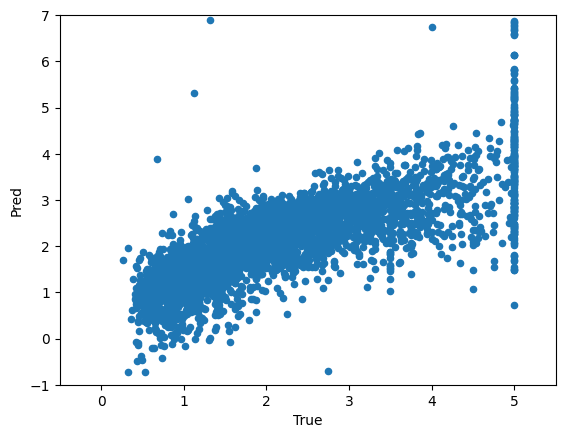

In [21]:
df_plot = pd.DataFrame([y_val.tolist(), y_val_pred]).T
df_plot.rename(columns={0: "True", 1: "Pred"}, inplace=True)
df_plot.plot.scatter(x='True', y='Pred', xlim=[-0.5, 5.5], ylim=[-1, 7])

#### Without MLFlow

In [22]:
from typing import NamedTuple
import kfp
import kfp.components as comp


def train_ml_model(input_csv: comp.InputPath('CSV'), datasplit_seed: int) -> NamedTuple('Outputs', [('val_mse', float), ('val_mae', float)]):
    """
    Some training
    """
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import (
        mean_absolute_error,
        mean_squared_error
    )
    import numpy as np
    from sklearn.linear_model import LinearRegression
    import pandas as pd
    
    df = pd.read_csv(input_csv)

    # Split Features and Labels
    X = df.drop(['AveRooms', 'MedHouseVal'], axis=1)
    y = df['MedHouseVal']

    # Split the data for train (80%) and validation (20%)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=datasplit_seed)

    linear_reg = LinearRegression().fit(X_train, y_train)

    y_val_pred = linear_reg.predict(X_val)

    val_mse = mean_absolute_error(y_val, y_val_pred)
    val_mae = mean_squared_error(y_val, y_val_pred)
    
    return (val_mse, val_mae)

In [23]:
train_model = kfp.components.create_component_from_func(
    func=train_ml_model,
    output_component_file='ml_training.yaml', # This is optional. It saves the component spec for future use.
    base_image='python:3.10',
    packages_to_install=['pandas==1.5.3', 'scikit-learn==1.2.2', 'numpy==1.23.5'])

In [29]:
from typing import NamedTuple

def train_ml_model_with_mlflow(input_csv: comp.InputPath('CSV'), datasplit_seed: int) -> NamedTuple('Outputs', [('val_mse', float), ('val_mae', float), ('model_location', str)]):
    """
    Some training
    """
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import (
        mean_absolute_error,
        mean_squared_error
    )
    import numpy as np
    from sklearn.linear_model import ElasticNet
    import pandas as pd
    import mlflow
    
    df = pd.read_csv(input_csv)

    # Split Features and Labels
    X = df.drop(['AveRooms', 'MedHouseVal'], axis=1)
    y = df['MedHouseVal']

    # Split the data for train (80%) and validation (20%)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=datasplit_seed)
    
    with mlflow.start_run(run_name='my_kfp_house_reg'):
        elastic_net_reg = ElasticNet(alpha=0.5, l1_ratio=0.5, random_state=42)
        elastic_net_reg.fit(X_train, y_train)
        result = mlflow.sklearn.log_model(elastic_net_reg, "model")        

    y_val_pred = elastic_net_reg.predict(X_val)

    val_mse = mean_absolute_error(y_val, y_val_pred)
    val_mae = mean_squared_error(y_val, y_val_pred)
    
    return (val_mse, val_mae, f"{mlflow.get_artifact_uri()}/{result.artifact_path}")

In [30]:
train_mlf_model = kfp.components.create_component_from_func(
    func=train_ml_model_with_mlflow,
    output_component_file='ml_training_w_mlf.yaml', # This is optional. It saves the component spec for future use.
    base_image='python:3.10',
    packages_to_install=['pandas==1.5.3', 'scikit-learn==1.2.2', 'numpy==1.23.5', 'mlflow==2.2.2'])

## Create a pipeline and compile

In [31]:
# Define a pipeline and create a task from a component:
def my_ml_pipeline(datasplit_seed: int):
    load_task = load_data_from_web()
    preprocess_task = preprocess_data(input_csv=load_task.outputs['output_csv'])
    train_task = train_model(input_csv=preprocess_task.outputs['output_csv'], datasplit_seed=datasplit_seed)
    # The outputs of the merge_csv_task can be referenced using the
    # merge_csv_task.outputs dictionary: merge_csv_task.outputs['output_csv']
    
# Define a pipeline and create a task from a component:
def my_ml_pipeline_with_kfp(datasplit_seed: int):
    load_task = load_data_from_web()
    preprocess_task = preprocess_data(input_csv=load_task.outputs['output_csv'])
    train_task = train_mlf_model(input_csv=preprocess_task.outputs['output_csv'], datasplit_seed=datasplit_seed)
    # The outputs of the merge_csv_task can be referenced using the
    # merge_csv_task.outputs dictionary: merge_csv_task.outputs['output_csv']

In [32]:
kfp.compiler.Compiler().compile(
    pipeline_func=my_ml_pipeline,
    package_path='ml_pipeline_demo.yaml')

In [33]:
kfp.compiler.Compiler().compile(
    pipeline_func=my_ml_pipeline_with_kfp,
    package_path='ml_pipeline_w_mlf_demo.yaml')